In [1]:
import os
import shutil
import numpy
import math
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.autograd import Variable
from pytorch_fid import inception
from torchvision.models.inception import inception_v3
from PIL import Image
from scipy import linalg
from scipy.stats import entropy
import wget
import patoolib

In [2]:
os.mkdir('unfiltered')
data_path = r'./unfiltered'
os.mkdir('filtered')
target_path= r'./filtered'
os.mkdir('examples')
os.mkdir('trained_models')

In [ ]:
URL = "https://drive.google.com/u/0/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t" 
response = wget.download(URL, "thecarconnectionpicturedataset.rar")

In [ ]:
patoolib.extract_archive("thecarconnectionpicturedataset.rar", outdir= "unfiltered/")

In [3]:
listOfFiles = os.listdir(data_path)
car_types= ['Convertible','Pickup','Station Wagon','4dr','3dr','2dr','SUV','Van']  # reszta to 'nan'
car_dictionary = dict.fromkeys(car_types)
for type_of_car in car_types:
    str_match = [s for s in listOfFiles if type_of_car+"_" in s]
    car_dictionary[type_of_car] = len(str_match)
    # ponizej tworzenie folderow z posortowanymi juz zdjeciami typow, czyli tzw. klas
    os.mkdir(os.path.join(target_path,type_of_car))
    target_dir = os.path.join(target_path,type_of_car)
    for fname in str_match:
        # przenoszenie plikow do wlasciwych folderow
        shutil.move(os.path.join(data_path,fname), target_dir)

In [ ]:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

if cuda:
  import cupy as cp
  print("You are working with CUDA")
  device=torch.device('cuda')
else:
  import numpy as cp
  print("You are working with CPU")
  device = torch.device('cpu')

In [5]:
## inicjalizacja parametrow
number_of_classes = len(car_types)
number_of_epochs = 20

image_size_width = 256
image_size_height = 256
mage_size=(image_size_width,image_size_height)
channels = 3 # RGB
img_shape_tuple = (channels, image_size_width, image_size_height)
img_shape = cp.array([channels, image_size_width, image_size_height])

batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent_size = 128  # rozmiar wektora wejsciowego do generatora

# wybor, ile wierszy i kolumn obrazow samochodow ma zostac wygenerowanych 
# (zestawienie w macierzy kwadratowej o rozmiarze NxN)
N=5

# konwersja obrazu do tensora z odpowiednimi warunkami
train_ds = ImageFolder(target_path, transform=T.Compose([
    T.Resize((image_size_height,image_size_width)),
    T.ToTensor(),
    T.Normalize(*stats)]))

# zbiór treningowy
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


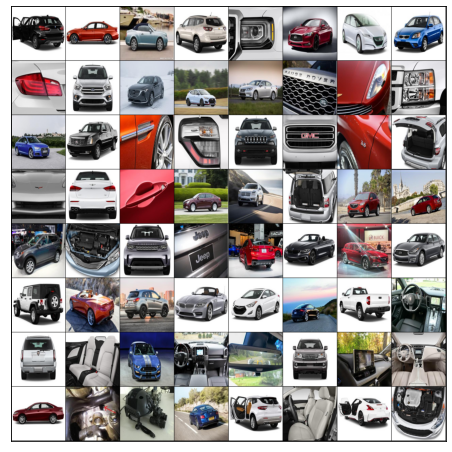

In [6]:
## pokazanie przykladowego batcha ze zdjeciami samochodow

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [7]:
## klasa generatora

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(number_of_classes, number_of_classes,device=device)

        self.linear = nn.Linear(latent_size + number_of_classes, 256)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 4, 2, 1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # konkatenacja etykiet z tensorem reprezenetujacym obraz
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        gen_input = self.linear(gen_input)
        gen_input = gen_input.reshape(gen_input.shape[0], -1, 1, 1)
        img = self.model(gen_input)
        return img

In [8]:
## klasa dyskryminatora
class Discriminator(nn.Module):
    def __init__(self):
            super(Discriminator, self).__init__()

            self.label_embedding = nn.Embedding(number_of_classes, number_of_classes,device=device)

            self.conv = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Flatten(),
                nn.Sigmoid()
            )

            self.linear = nn.Sequential(
                nn.Linear(number_of_classes + 64*16*16, 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 128),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(128, 32),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )

    def forward(self, img, labels):
        # konkatenacja etykiet z tensorem reprezenetujacym obraz
        conv = self.conv(img)
        embeds = self.label_embedding(labels)
        d_in = torch.cat((conv, embeds), -1)
        validity = self.linear(d_in)
        return validity

In [9]:
# jako funkcja straty binarna entropia krzyzowa
fun_loss = nn.BCELoss()

# inicjalizacja generatora i dyskyminatora
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# wykorzystanie algorytmu Adam do optymalizacji procesu uczenia metodą spadku gradientu
b1=0.5
b2=0.999
generator_lrate=0.0002
discriminator_lrate = 0.0002
optimizer_D = optim.Adam(discriminator.parameters(), lr=discriminator_lrate, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=generator_lrate, betas=(b1, b2))

In [10]:
def sample_image(n_row, batches_done):
    """zapisywanie obrazów wygenerowanych przez klasę generatora"""
    # losowy szum
    z = Variable(FloatTensor(cp.random.normal(0, 1, (n_row ** 2, latent_size))))
    labels = cp.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    # wygenerowanie obrazow
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "./examples/%d.png" % batches_done, nrow=n_row, normalize=True)

In [11]:
# usuwanie przykladowych obrazow z poprzedniej sesji nauki
folder = './examples'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
# ----------
#  Training
# ----------

d_loss_iteration=[]
g_loss_iteration=[]

for epoch in range(number_of_epochs):
    for i, (imgs, labels) in enumerate(train_dl):

        batch_size = imgs.shape[0]

        # tensory "prawdy" dla dyskryminatora
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # konfiguracja obrazow ze zbioru treningowego
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  trenowanie generatora
        # -----------------

        optimizer_G.zero_grad()

        # szum i etykiety dla generatora
        z = Variable(FloatTensor(cp.random.normal(0, 1, (batch_size, latent_size))))
        gen_labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, batch_size)))

        # Generacja obrazów
        gen_imgs = generator(z, gen_labels)
        # wyliczenie straty generatora
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = fun_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  trenowanie dyskryminatora
        # ---------------------

        optimizer_D.zero_grad()

        # strata dla realnych obrazow ze zbioru treningowego
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = fun_loss(validity_real, valid)

        # strata dla falszywych obrazow od generatora
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = fun_loss(validity_fake, fake)

        # calkowita straty dla dyskryminatora
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch + 1, number_of_epochs, i + 1, len(train_dl), d_loss.item(), g_loss.item())
        )

        d_loss_iteration.append(d_loss.item())
        g_loss_iteration.append(g_loss.item())

        # co 100 iteracji, zapisywanie przykladowych zdjec od generatora
        batches_done = epoch * len(train_dl) + i
        if batches_done % 100 == 0:
            sample_image(n_row=N, batches_done=batches_done)


torch.cuda.empty_cache()

In [ ]:
# rysowanie wartosci funkcji straty dla obu klas sieci
number_of_iterations=range(1,number_of_epochs*len(train_dl)+1)
plt.plot(number_of_iterations,g_loss_iteration)
plt.plot(number_of_iterations,d_loss_iteration)
plt.xlabel('iterations')
plt.ylabel('values of loss function')
plt.title('Loss function')
plt.legend(['for generator', 'for discriminator'],loc='best')

In [19]:
# zapisz wytrenowany model (opcjonalne)
torch.save(generator.state_dict(), './trained_models/generator.pt')

In [ ]:
# zaladuj wytrenowany model (opcjonalne)
generator = Generator().to(device)
generator.load_state_dict(torch.load('./trained_models/generator.pt'))
generator.eval()

In [21]:
# wygeneruj i zapisz przukladowe obrazy dla kazdej z klas
classes = Variable(LongTensor(range(len(car_types))))
noise = Variable(FloatTensor(cp.random.normal(0, 1, (len(car_types), latent_size))))
gen_imgs = generator(noise, classes)
save_image(gen_imgs.data, "./examples/final.png", normalize=True)

In [12]:
# funkcja wyliczająca FID

######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = numpy.mean(distribution_1, axis=0)
    sigma1 = numpy.cov(distribution_1, rowvar=False)

    mu2 = numpy.mean(distribution_2, axis=0)
    sigma2 = numpy.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = numpy.atleast_1d(mu1)
    mu2 = numpy.atleast_1d(mu2)

    sigma1 = numpy.atleast_2d(sigma1)
    sigma2 = numpy.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not numpy.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = numpy.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if numpy.iscomplexobj(covmean):
        if not numpy.allclose(numpy.diagonal(covmean).imag, 0, atol=1e-3):
            m = numpy.max(numpy.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = numpy.trace(covmean)

    return (diff.dot(diff) + numpy.trace(sigma1) +
            numpy.trace(sigma2) - 2 * tr_covmean)

In [13]:
# funkcja wyliczająca IS

######### Inception Score based on implementation from https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py
from scipy.stats import entropy
from torchvision.models.inception import inception_v3

def calculate_inception_score(imgs, cuda=True, batch_size=30, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # # Load inception model
    model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    model.eval();

    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = model(x)
        print(type(x))
        return nn.functional.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = numpy.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = numpy.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(numpy.exp(numpy.mean(scores)))

    return numpy.mean(split_scores), numpy.std(split_scores)

In [14]:
# ewaluacja sieci GAN
noise = Variable(FloatTensor(cp.random.normal(0, 1, (40, latent_size))))
labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, 40)))
generated_imgs = generator(noise, labels)

# wyliczanie FID
dims = 2048 # ile wyjsc fragmentu sieci z InceptionV3
block_idx = inception.InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = inception.InceptionV3([block_idx]).to(device)
loader = DataLoader(train_ds, 30, shuffle=True)
orig_imgs, orig_labels = iter(loader).next()
generated_dist = model(generated_imgs)[0]
orig_dist = model(orig_imgs.to(device))[0]
orig_dist = orig_dist.cpu()
generated_dist = generated_dist.cpu()
fid = calculate_frechet_distance(orig_dist.squeeze().detach().numpy(), 
                                generated_dist.squeeze().detach().numpy())

print(f'Frechet Inception Distance score: {fid}')

# wyliczanie IS
ins = calculate_inception_score(generated_imgs, cuda=cuda, batch_size=30, resize=True, splits=5)
print(f'Inception Score: {ins}')

Frechet Inception Distance score: 109.36597783723427
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Inception Score: (1.0000070804895835, 4.852811493455849e-06)


/tmp/ipykernel_34111/4023822382.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x).data.cpu().numpy()
